<>:143: SyntaxWarning: invalid escape sequence '\m'
<>:143: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7268/4168455803.py:143: SyntaxWarning: invalid escape sequence '\m'
  '''


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

1889808


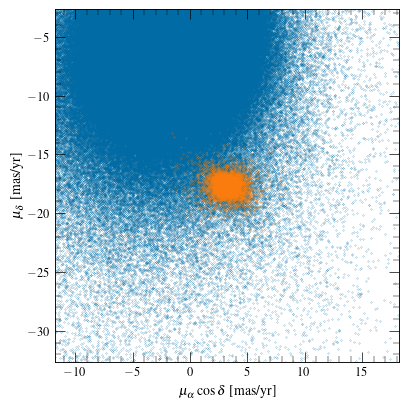

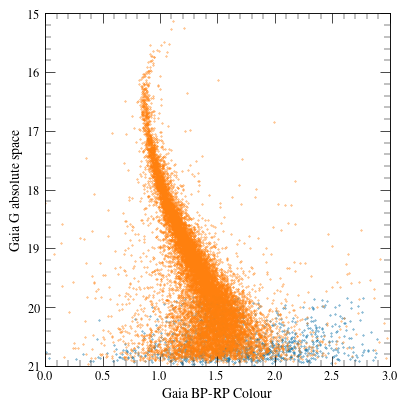

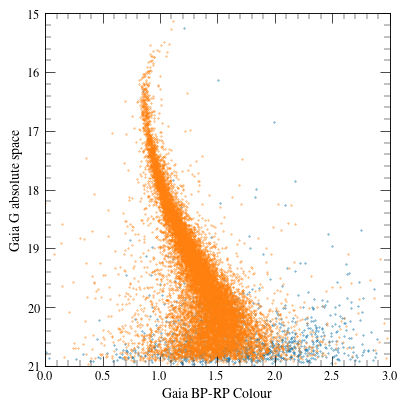

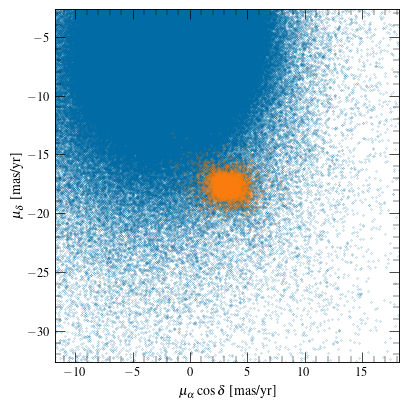

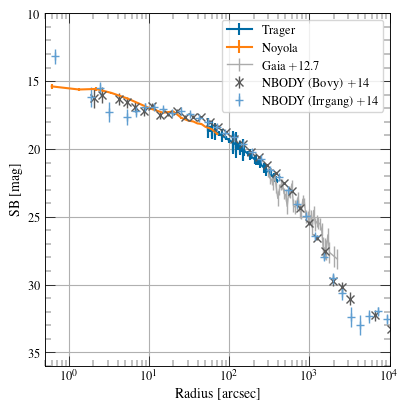

In [1]:
from IPython.display import display, Math, HTML, Image
import orbits 

#%config InlineBackend.figure_formats = ['svg']
from astropy.visualization import quantity_support, astropy_mpl_style
quantity_support()  
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib_inline
#matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
mpl.style.use('default')
mpl.style.use('tableau-colorblind10')
mpl.style.use('./MNRAS_Style.mplstyle')
mpl.rcParams['figure.figsize'] = [12/3, 12/3]
#mpl.rcParams['figure.dpi'] = 72

# in points - start with the body text size and play around
SMALL_SIZE = 9
MEDIUM_SIZE = 10
BIGGER_SIZE = 9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

display(HTML("<h1>NGC 6397</h1>"))
# display(Image(url='https://upload.wikimedia.org/wikipedia/commons/9/99/P0321a.jpg', width=1024))

display(Math('\\text{{RA}} = {}^{{\\circ}}'.format(orbits.RA)))
display(Math('\\text{{DEC}} = {}^{{\\circ}}'.format(orbits.DEC)))
display(Math('\\mu_\\alpha \\cos\\delta = {} \\pm {}^{{\\circ}}'.format(*orbits.PMRA)))
display(Math('\\delta = {} \\pm {}^{{\\circ}}'.format(*orbits.PMDEC)))
display(Math('R_\\odot = {}\\text{{ kpc}}'.format(orbits.RSUN)))
display(Math('\\sigma = {}\\text{{ mas/yr}}'.format(orbits.SIGMA)))


import gaia
import numpy as np


#nbody = np.loadtxt('2023-11-05/ngc6397.out')
nbody = np.loadtxt('2024-04-07/ngc6397.out')
nbody_irr = np.loadtxt('2024-04-28/ngc6397.out')

display(Math('N_\\text{{initial}} = {}'.format(len(gaia.data))))

# Clean out bad data
clean = gaia.data['bp_rp'] != 0

display(HTML('Cleaning for zero BP-RP'))
display(Math('N_\\text{{clean}} = {}'.format(np.sum(clean))))


# Perform a proper motion cut
cut = clean
cut &= np.abs(gaia.data['pmra'] - orbits.PMRA[0]) < (2 * gaia.data['pmra_error'])
cut &= np.abs(gaia.data['pmdec'] - orbits.PMDEC[0]) < (2 * gaia.data['pmdec_error'])


display(HTML('Proper motion cut'))
display(Math('\\lvert \\mu_\\alpha \\cos\\delta_i - \\mu_\\alpha \\cos\\delta \\rvert < 2 \\epsilon_{{\\mu_\\alpha \\cos\\delta_i}}'))
display(Math('\\lvert \\mu_{\\delta_i }- \\mu_{\\delta} \\rvert < 2 \\epsilon_{{\\mu_{\\delta_i}}}'))
display(Math('N_\\text{{pm}} = {}'.format(np.sum(cut))))


def draw_pm(save=False, outer=None):
    # Draw a proper motion diagram.
    fig, ax = plt.subplots(ncols=1)
    fig.tight_layout()
    ax.set(
        xlim=[orbits.PMRA[0]-15, orbits.PMRA[0]+15],
        ylim=[orbits.PMDEC[0]-15, orbits.PMDEC[0]+15]
    )
    ax.set_xlabel(r'$\mu_{\alpha} \cos \delta$ [mas/yr]')
    ax.set_ylabel(r'$\mu_{\delta}$ [mas/yr]')
    
    # Stars outside the proper motion space
    ax.scatter(gaia.data['pmra'][bg], gaia.data['pmdec'][bg], s=0.1, marker='.')
    
    # Stars inside the proper motion space
    ax.scatter(gaia.data['pmra'][cut], gaia.data['pmdec'][cut], s=0.1, marker='.')

    # Other stars
    if outer is not None:
        ax.scatter(gaia.data['pmra'][outer], gaia.data['pmdec'][outer], s=0.3, color='black', marker=(5,1))
    
    if save:
        fig.savefig('pm.png')

#draw_pm()


# Perform a statistical selection
chi2 = 5
cut &= (gaia.data['pmra'] - orbits.PMRA[0])**2 / (orbits.SIGMA_RA**2 + gaia.data['pmra_error']**2) + \
       (gaia.data['pmdec'] - orbits.PMDEC[0])**2 / (orbits.SIGMA_DEC**2 + gaia.data['pmdec_error']**2) <= chi2


display(HTML('Statistical criterion cut'))
display(Math('''\\chi^2 = \\frac{(\\mu_\\alpha \\cos\\delta_i - \\mu_\\alpha \\cos\\delta)^2}{(\\sigma^2 + \\epsilon_{{\\mu_\\alpha \\cos\\delta}})^2} + \\
                \\frac{(\\mu_{\\delta_i} - \\mu_{\\delta_i})^2}{(\\sigma^2 + \\epsilon_{{\\mu_{\\delta_i}}})^2} \\le 5''')) 
display(Math('N_{{\\chi^2}} = {}'.format(np.sum(cut))))

pm_cut = cut.copy()
#draw_pm()


# Perform a colour-magnitude cut
from scipy import stats
from geom import angular_dist, deg2rad

# Seperate the cluster into inside 0.5 degree radius and outside.
distances = angular_dist(gaia.data['ra'], gaia.data['dec'], orbits.RA, orbits.DEC)
inside = distances < deg2rad(0.5)

# Find all of the faint stars (mag > 19.8) 
faint = gaia.data['phot_g_mean_mag'] > 19.8

# Of the stars outside the 0.5 deg radius, determine if
# the angular separation is of the same distribution.
g1 = cut & ~inside & faint
g2 = cut & ~inside & ~faint
result = stats.kstest(distances[g1], distances[g2])

# If reasonably certain the two groups are different,
# throw away the faint ones.
if result.pvalue < 0.05:
    display(HTML("Throwing away the faint ones."))
    cut &= ~g1


display(HTML('Final selection'))
display(Math('N_\\text{{final}} = {}'.format(np.sum(cut))))
bg = (gaia.data['bp_rp'] != 0) & ~cut
draw_pm(True)

# Draw a PM diagram for nbody
'''
nbody = np.loadtxt('2023-11-05/ngc6397.out')
fig, ax = plt.subplots(ncols=1)

ax.set(
    title=r'Proper motion space - NBODY',
    xlim=[orbits.PMRA[0]-20, orbits.PMRA[0]+20],
    ylim=[orbits.PMDEC[0]-20, orbits.PMDEC[0]+20]
)
ax.set_xlabel(r'$\mu_{\alpha} \cos \delta$ [mas/yr]')
ax.set_ylabel(r'$\mu_{\delta}$ [mas/yr]')

# Stars inside the proper motion space
ax.scatter(nbody[:,4], nbody[:,5], color='g', s=0.1, marker='.')
'''


# Draw a colour-magnitude diagram

bg = pm_cut & ~cut
print(len(bg))

fig, ax = plt.subplots(ncols=1)
fig.tight_layout()
ax.invert_yaxis()
ax.set_xlabel('Gaia BP-RP Colour')
ax.set_ylabel('Gaia G absolute space')
ax.set(
    #title=r'Colour-magnitude Diagram',
    xlim=[0.0, 3.0],
    ylim=[21, 15]
)


ax.scatter(gaia.data['bp_rp'][bg], gaia.data['phot_g_mean_mag'][bg], s=0.1)
ax.scatter(gaia.data['bp_rp'][cut], gaia.data['phot_g_mean_mag'][cut], s=0.1)

fig.savefig('cm.png')



'''
# Plot the spatial coordinates
fig, ax = plt.subplots(ncols=1)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title('Celestial coordinates - Gaia')

ax.set(
    xlim=[245,285],
    ylim=[-65,-40]
)
ax.scatter(gaia.data['ra'][cut], gaia.data['dec'][cut], color='b', marker='o', s=10)

fig, ax = plt.subplots(ncols=1)

ax.set(
    xlim=[245,285],
    ylim=[-65,-40]
)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title('Celestial coordinates - NBODY')
ax.scatter(nbody[:,1], nbody[:,2], color='g', marker='.', s=10)
'''



def sdens_to_sb(n):
    return (-2.5) * np.log10(n)

def surface_density(d, ax, label, scale=17, lw=1, fmt=''):
    logmin = np.log10(np.amin(d))
    logmax = np.log10(np.amax(d))
    logbins = np.logspace(logmin, logmax, 50)
    counts, bins = np.histogram(d, bins=logbins)
    cut = counts > 0
    
    # Divide the sum in each bin by the area of the annulus
    r_b = bins[:-1]
    area = np.array([
      np.pi * (bins[i+1]**2 - r**2)
      for i,r in enumerate(r_b)
    ])[cut]
    
    n_area = counts[cut] / area 
    nsq_area = np.sqrt(counts[cut]) / area 
    y = -2.5 * np.log10(n_area)
    #y = n_area
    
    error = -2.5 * np.log10(n_area+nsq_area) - y
    #error = nsq_area
    #scale = 0
    #error = np.log10(nsq_area)
    #error = np.log10(y) - np.log10(np.sqrt(counts[cut]))
    #error = y / np.sqrt(n_area)
    #err = (y / np.sqrt(n_area))
    
    ax.errorbar(r_b[cut], y+scale, yerr=np.abs(error), label=label, lw=lw, elinewidth=1, fmt=fmt)
    #ax.plot(r_b[cut], n_area, label=label, lw=lw)

def centre_dist(ra, dec):
    return 3600.0 * np.sqrt((ra-orbits.RA)**2 * np.cos(orbits.DEC/180.0*np.pi)**2+(dec-orbits.DEC)**2) 



def plot_surface_density(cut, name):
    bright = gaia.data['phot_g_mean_mag'] < 17
    
    # Stitch with Trager et al.
    from geom import rad2arcsec
    trager = np.loadtxt('ngc6397_trager.dat')
    noyola = np.loadtxt('n6397_SB_noyola.txt')
    
    fig, ax = plt.subplots(ncols=1)
    fig.tight_layout()
    
    #ax.set_title('Surface Brightness (Bovy)')
    ax.set_xlabel(r'Radius [arcsec]')
    ax.set_ylabel(r'SB [mag]')
    ax.set_xscale("log")
    ax.grid()
    ax.invert_yaxis()
    
    ax.set(
        ylim=[36, 10],
        xlim=[0.5, 10000]
    )
    
    # ax.set(title="Surface Density")
    
    # Plot tager
    # ax.plot(10**trager[:,0], trager[:,2], label='Trager')
    trager_err = np.abs(trager[:,3])
    cut_trager = (trager_err < 1) & (trager[:,0] > 1.7) & (trager[:,0] < 2.6)
    ax.errorbar(10**trager[:,0][cut_trager], trager[:,2][cut_trager], yerr=trager_err[cut_trager], label='Trager')
    #ax.plot(10**trager[:,0][cut_trager], 10**(-0.4*trager[:,2][cut_trager]), label='Trager')
    
    # Plot Noyola
    noyola_err = np.abs(noyola[:,2])
    cut_noyola = (noyola_err < 1)
    ax.errorbar(10**noyola[:,0][cut_noyola], noyola[:,1][cut_noyola], yerr=noyola_err[cut_noyola], label='Noyola')
    #ax.plot(10**noyola[:,0][cut_noyola], 10**(-0.4*noyola[:,1][cut_noyola]), label='Noyola')
    
    # Stitch Gaia
    gaia_cut = gaia.data[cut & bright]
    #arcsec_distance = rad2arcsec(angular_dist(gaia_cut['ra'], gaia_cut['dec'], orbits.RA, orbits.DEC))
    #arcsec_distance = 3600.0 * np.sqrt((gaia_cut['ra']-orbits.RA)**2 * np.cos(orbits.DEC/180.0*np.pi)**2+(gaia_cut['dec']-orbits.DEC)**2) 
    arcsec_distance = centre_dist(gaia_cut['ra'], gaia_cut['dec'])
    surface_density(arcsec_distance[arcsec_distance > 300], ax, 'Gaia $+12.7$', scale=12.7)
    
    # Get nbody form
    #m80 = (nbody[:,7] > 0.8) & (nbody[:,8] < 10)
    
    #nbdis = rad2arcsec(angular_dist(nbody[:,1][m80], nbody[:,2][m80], orbits.RA, orbits.DEC))
    
    #surface_density(nbdis, ax, 'NBODY 4gyr $+16$', fmt='g-', scale=16, lw=3)
    
    
    ax.legend()
    fig.savefig(f'{name}.png')
    
    # Get nbody form
    def get_nbdis(nb):
        m80 = (nb[:,7] > 0.78) & (nb[:,7] < 0.9) & (nb[:,8] < 6)
        return 3600.0 * np.sqrt((nb[:,1][m80]-orbits.RA)**2 * np.cos(orbits.DEC/180.0*np.pi)**2+(nb[:,2][m80]-orbits.DEC)**2) 

    nbdis = get_nbdis(nbody)
    nbdis_irr = get_nbdis(nbody_irr)
    surface_density(nbdis, ax, 'NBODY (Bovy) $+14$', scale=14, lw=3, fmt='x')
    surface_density(nbdis_irr, ax, 'NBODY (Irrgang) $+14$', scale=14, lw=3, fmt='+')
    ax.legend()
    fig.savefig(f'{name}-nb.png')


#plot_surface_density(cut, 'sb')

fig, ax = plt.subplots(ncols=1)
fig.tight_layout()
ax.invert_yaxis()
ax.set_xlabel('Gaia BP-RP Colour')
ax.set_ylabel('Gaia G absolute space')
ax.set(
    #title=r'Colour-magnitude Diagram',
    xlim=[0.0, 3.0],
    ylim=[21, 15]
)

# remove the outer
outer = cut & (centre_dist(gaia.data['ra'], gaia.data['dec']) > 3000)
cut = cut & ~outer
bg = pm_cut & ~cut


ax.scatter(gaia.data['bp_rp'][bg], gaia.data['phot_g_mean_mag'][bg], s=0.1)
ax.scatter(gaia.data['bp_rp'][cut], gaia.data['phot_g_mean_mag'][cut], s=0.1)
#ax.scatter(gaia.data['bp_rp'][outer], gaia.data['phot_g_mean_mag'][outer], color='black', marker=(5, 1), s=0.3)

#fig.savefig('cm-with-flattening.png')

bg = (gaia.data['bp_rp'] != 0) & ~cut
draw_pm()#outer=outer)


plot_surface_density(cut, 'sb2')


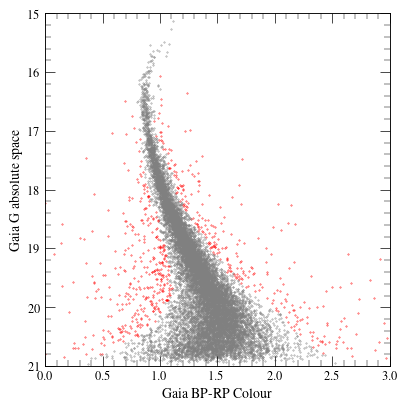

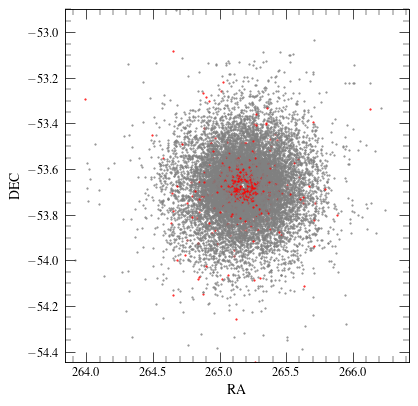

In [2]:

from astropy.stats import sigma_clip

def fit_cm():
    fig, ax = plt.subplots(ncols=1)
    fig.tight_layout()

    ax.invert_yaxis()
    ax.set_xlabel('Gaia BP-RP Colour')
    ax.set_ylabel('Gaia G absolute space')
    ax.set(
        #title=r'Colour-magnitude Diagram',
        xlim=[0.0, 3.0],
        ylim=[21, 15]
    )

    fig1, ax1 = plt.subplots(ncols=1)
    fig1.tight_layout()
    #ax1.set(
    #    xlim=[245,285],
    #    ylim=[-65,-40]
    #)
    ax1.set_xlabel('RA')
    ax1.set_ylabel('DEC')

    means = []
    stdevs = []
    bins = np.arange(14, 22, 0.1)
    
    for b in bins:
        band = cut & (gaia.data['phot_g_mean_mag'] >= b) & (gaia.data['phot_g_mean_mag'] < b + 0.1)
        x = gaia.data['phot_g_mean_mag'][band]
        y = gaia.data['bp_rp'][band]
        clipped = sigma_clip(y, sigma=3, maxiters=10)
    
        ax.scatter(y[~clipped.mask], x[~clipped.mask], s=0.1, color='gray')
        ax.scatter(y[clipped.mask], x[clipped.mask], s=0.1, color='red')

        ax1.scatter(gaia.data['ra'][band][~clipped.mask], gaia.data['dec'][band][~clipped.mask], color='gray', marker='.', s=1)
        ax1.scatter(gaia.data['ra'][band][clipped.mask], gaia.data['dec'][band][clipped.mask], color='red', marker='.', s=1)
        
        '''
        m = np.mean(gaia.data['bp_rp'][band])
        sig = np.std(gaia.data['bp_rp'][band])
        means.append(m)
        stdevs.append(sig)
        
        
        inside = band & (np.abs(gaia.data['bp_rp'] - m) < 3*sig)
        outside = band & ~inside

        #print(b, m, sig, np.sum(band), np.sum(inside), np.sum(outside))
        
        ax.scatter(gaia.data['bp_rp'][inside], gaia.data['phot_g_mean_mag'][inside], s=0.1, color='gray')
        #ax.scatter(gaia.data['bp_rp'][outside], gaia.data['phot_g_mean_mag'][outside], s=0.1, color='black')

        '''
        
    #ax.errorbar(means, bins, xerr=stdevs)
    fig.savefig('cm-binned.png')

fit_cm()

In [3]:

"""
def get_cen(nb):
    cut = nb[:2000,1:3]
    dis = np.sum((cut[:,np.newaxis] - nb[:,1:3])**2, axis=2)
    dens = 1.0 / np.amin(dis, where=dis>0, axis=1, initial=1e10)**3
    weight = np.sum(dens)
    return np.sum(cut * dens[:,np.newaxis], axis=0) / weight
    
    
nb8_cen = get_cen(nbody)
print(nb8_cen)
"""
#nb8_cen = [270.164528, -54.355833]
#nb8_cen = [265.175385   ,-53.674335 ]

nb8_cen = [orbits.RA, orbits.DEC]

0.5084346379335727


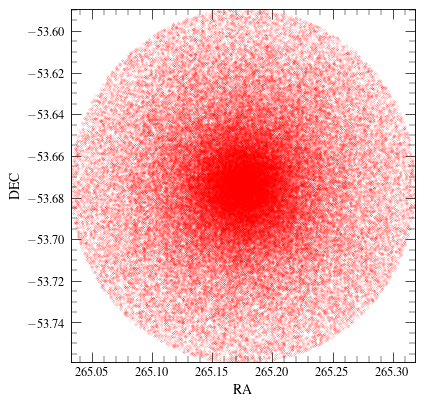

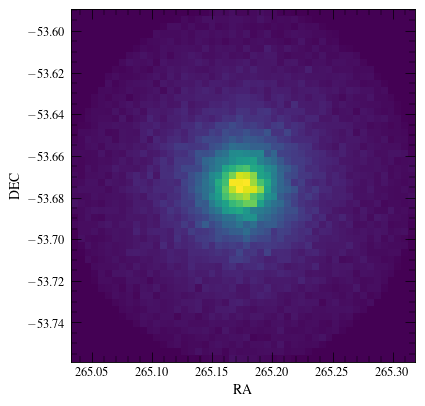

In [4]:
fig, ax = plt.subplots()
fig.tight_layout()

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

# Get all nbody particles +/- 10 deg from nb8_cen
alpha, delta = np.radians([orbits.RA, orbits.DEC])
nb_delta = np.radians(nbody[:,2])
nb_alpha = np.radians(nbody[:,1])

dist = np.arccos(
    np.sin(nb_delta)*np.sin(delta) +
    np.cos(nb_delta)*np.cos(delta) * np.cos(nb_alpha - alpha)
)

close = dist < np.radians(0.085)
ax.plot(nbody[:,1][close], nbody[:,2][close], 'ro', ms=0.1)
print(np.sum(nbody[:,7][close]) / np.sum(nbody[:,7]))
# ===

fig, ax = plt.subplots()
fig.tight_layout()
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
_=ax.hist2d(nbody[:,1][close], nbody[:,2][close], 50, weights=nbody[:,7][close], density=True)


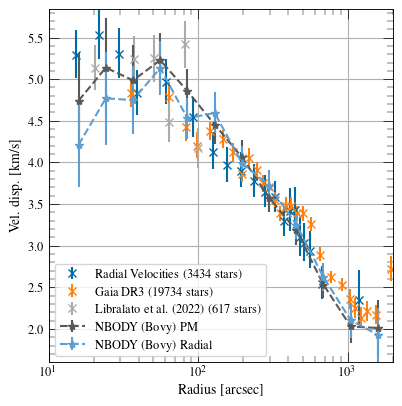

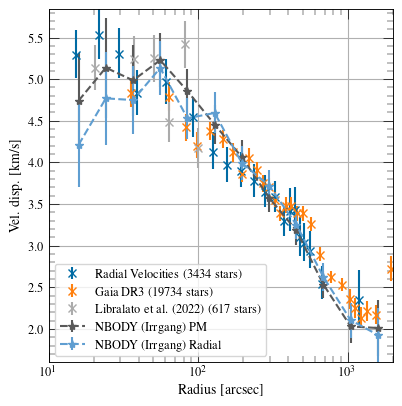

In [5]:
# Vel. disp.
from astropy import units as u
import veldis
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

def plot_velocity_dispersion(nb, label, save):
    
    fig, ax = plt.subplots()
    fig.tight_layout()
    
    
    #ax.set_title('Velocity Dispersion - Bovy Potential w/Evolution')
    #axes[1].set_title('Velocity Dispersion - Tangential')
    
    #for ax in axes:
    ax.set_xlabel(r'Radius [arcsec]')
    ax.set_ylabel(r'Vel. disp. [km/s]')
    ax.set_xscale("log")
    ax.set_xlim(left=10, right=2000)
    ax.grid()
    #ax.yaxis.grid(True, which='minor')
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    
    def get_veldis(vel, dx, logbins=None):
        if logbins is None:
            logbins = np.logspace(1.2, 3.2, num=12)
            
        hi = 10**(np.log10(logbins[-1])+0.1)
        
        nbinner = (dx < hi)
        nb_v_mean = np.mean(vel[nbinner])
        outlier = (np.abs(vel - nb_v_mean) > 25)
        
        hist = []
        bins = []
        errs = []
        ns = 0
        r_0 = 0
        for i,r in enumerate(logbins):
            r_1 = 10**(np.log10(r)+0.1)
            
            bds = ~outlier & (dx > r_0) & (dx < r_1)
            n = np.sum(bds)
            #if n == 0:
            #    continue
            s = np.sqrt(1/n * np.sum((vel[bds] - nb_v_mean)**2.0))
            ns += n
            error = s / np.sqrt(n)
    
            hist.append(s)
            bins.append(r)
            errs.append(error)
            r_0 = r_1
    
        return np.array(hist), np.array(errs), np.array(bins)
    
    
    def tangent_to_velocity(mas):
        return mas.value/3600/180*np.pi * orbits.RSUN * 3.085677E16 / 3.15576e7 / 1000
    
    
    def plot_veldis_nb(ax, label, nb, fmt='--*'):
        #ax1, ax2 = axes
        
        m80 = (nbody[:,8] < 6) & (nbody[:,7] > 0.78) &  (nbody[:,7] < 0.9)
        bright = nbody[m80]
        
        nbdx = 3600.0 * np.sqrt((bright[:,1]-nb8_cen[0])**2 * np.cos(nb8_cen[1]/180.0*np.pi)**2+(bright[:,2]-nb8_cen[1])**2) 
        
        ve = tangent_to_velocity(bright[:,4] * u.mas/u.yr)
        vn = tangent_to_velocity(bright[:,5] * u.mas/u.yr)
        nbpm = np.sqrt(ve**2 + vn**2)
        
        nbvd, nberr, nbvb = get_veldis(nbpm, nbdx)
        ax.errorbar(nbvb, nbvd, nberr, label=f'{label} PM', fmt=fmt)
        
        nbvr = bright[:,6] # * u.km/u.s
        nbvd, nberr, nbvb = get_veldis(nbvr, nbdx)
        ax.errorbar(nbvb, nbvd, yerr=nberr, label=f'{label} Radial', fmt=fmt)
        
        
        
    
    def plot_veldis_type(ax, t, label, **kwargs):
    
        vcut = (veldis.data_update['type'] == t) & (veldis.data_update['R'] > 10)
        verru = veldis.data_update['esig_u'][vcut]
        verrl = veldis.data_update['e_sigl'][vcut]
        verr = np.vstack((verrl, verru))
        ax.errorbar(veldis.data_update['R'][vcut], veldis.data_update['sig'][vcut], verr, label=label, **kwargs)
    
    
    plot_veldis_type(ax, 1, 'Radial Velocities (3434 stars)', fmt='x')
    #plot_veldis_type(axes[1], 1, 'Radial Velocities', martens=True, fmt='rx')
    plot_veldis_type(ax, 4, 'Gaia DR3 (19734 stars)', fmt='x')
    plot_veldis_type(ax, 2, 'Libralato et al. (2022) (617 stars)', fmt='x')
    #plot_veldis_type(axes[1], 4, 'Gaia-PM', fmt='b+')
    #plot_veldis_type(axes[1], 2, 'HST-PM', fmt='y.')
    
    #for ax in axes:
    ax.legend()
    fig.savefig('veldisp.png')
    
    plot_veldis_nb(ax, label, nb)
        
    ax.legend()
    fig.savefig(save)

plot_velocity_dispersion(nbody, 'NBODY (Bovy)', 'veldisp-nb-bovy.png')
plot_velocity_dispersion(nbody_irr, 'NBODY (Irrgang)', 'veldisp-nb-irr.png')



In [6]:
'''
from scipy.optimize import minimize

def vel_fac(f):
    m80 = (nbody[:,8] < 6) & (nbody[:,7] > 0.78) &  (nbody[:,7] < 0.9)
    bright = nbody[m80]
    dx = 3600.0 * np.sqrt((bright[:,1]-nb8_cen[0])**2 * np.cos(nb8_cen[1]/180.0*np.pi)**2+(bright[:,2]-nb8_cen[1])**2) 
    vr = bright[:,6]
    
    def sig(r):
        cut = dx <= r
        vm = np.mean(vr[cut])
        outlier = (np.abs(dx - vm) > 25)
        bds = ~outlier & cut
        n = np.sum(bds)
        return np.sqrt(1/n * np.sum((dx[bds] - vm)**2.0))
    
    nbs, _, _ = get_veldis(vr, dx, veldis.data_update['R'])
    cut = ~np.isnan(nbs)
    
    #nbs = np.array([sig(r) for r in veldis.data_update['R']])
    return np.sum((f*nbs[cut] - veldis.data_update['sig'][cut])**2 / (nbs[cut]**2 + veldis.data_update['sig'][cut]**2))


print(minimize(vel_fac, 5))
x = np.linspace(0.9, 1.2)
y = np.array([vel_fac(f) for f in x])
plt.plot(x, y)

'''


"\nfrom scipy.optimize import minimize\n\ndef vel_fac(f):\n    m80 = (nbody[:,8] < 6) & (nbody[:,7] > 0.78) &  (nbody[:,7] < 0.9)\n    bright = nbody[m80]\n    dx = 3600.0 * np.sqrt((bright[:,1]-nb8_cen[0])**2 * np.cos(nb8_cen[1]/180.0*np.pi)**2+(bright[:,2]-nb8_cen[1])**2) \n    vr = bright[:,6]\n    \n    def sig(r):\n        cut = dx <= r\n        vm = np.mean(vr[cut])\n        outlier = (np.abs(dx - vm) > 25)\n        bds = ~outlier & cut\n        n = np.sum(bds)\n        return np.sqrt(1/n * np.sum((dx[bds] - vm)**2.0))\n    \n    nbs, _, _ = get_veldis(vr, dx, veldis.data_update['R'])\n    cut = ~np.isnan(nbs)\n    \n    #nbs = np.array([sig(r) for r in veldis.data_update['R']])\n    return np.sum((f*nbs[cut] - veldis.data_update['sig'][cut])**2 / (nbs[cut]**2 + veldis.data_update['sig'][cut]**2))\n\n\nprint(minimize(vel_fac, 5))\nx = np.linspace(0.9, 1.2)\ny = np.array([vel_fac(f) for f in x])\nplt.plot(x, y)\n\n"

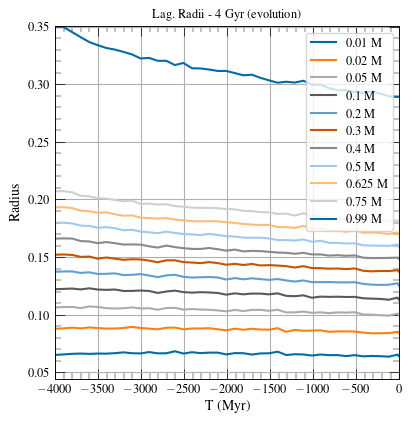

In [7]:

#lagr_ev = np.loadtxt('2023-11-05/fort.32')
lagr_ev = np.loadtxt('2024-04-07/fort.32')
FLAGR=[0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.625,0.75,0.99]

def plot_lagr(lagr, title, xrange):
    r = 300
    r = np.amax(lagr[:,1])
    fig, ax = plt.subplots(ncols=1, nrows=1)
    fig.tight_layout()

    ax.set_title(title)
    ax.set_xlabel(r'T (Myr)')
    ax.set_ylabel(r'Radius')
    #x.set_xscale("log")
    ax.set_xlim([-4000, 0])
    ax.grid()

    for i,f in enumerate(FLAGR):
        b = lagr[:,1] <= r
        ax.plot(lagr[:,1][b]-13500, lagr[:,i+2][b], label='{} M'.format(f))
    ax.legend()
        
plot_lagr(lagr_ev, "Lag. Radii - 4 Gyr (evolution)", [9500, 13500])
#plot_lagr(lagr_4gyr, "Lag. Radii - 4 Gyr (no evolution)", [0, 4000])

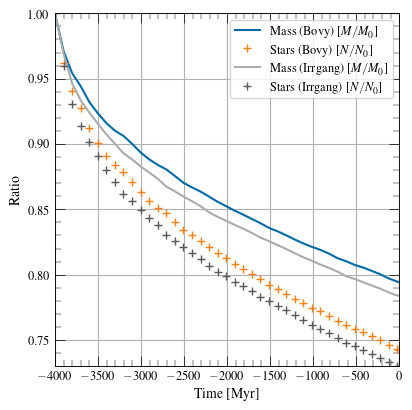

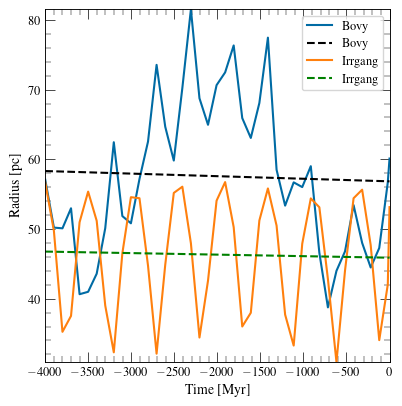

In [9]:
#boundm = np.loadtxt('2023-11-05/boundm')

boundm_bovy = np.loadtxt('2024-04-07/boundm')
boundm_irr = np.loadtxt('2024-04-28/boundm')
boundm_bovy[0,0] = 9500
boundm_irr[0,0] = 9500
    
fig, ax = plt.subplots()
fig.tight_layout()

ax.set_ylabel('Ratio')
ax.set_xlabel('Time [Myr]')
ax.grid()
ax.plot(boundm_bovy[:,0] - 13500, boundm_bovy[:,2], label='Mass (Bovy) [$M/M_0$]')
ax.plot(boundm_bovy[:,0] - 13500, boundm_bovy[:,3], '+', label='Stars (Bovy) [$N/N_0$]')

ax.plot(boundm_irr[:,0] - 13500, boundm_irr[:,2], label='Mass (Irrgang) [$M/M_0$]')
ax.plot(boundm_irr[:,0] - 13500, boundm_irr[:,3], '+', label='Stars (Irrgang) [$N/N_0$]')
ax.legend()
fig.savefig('boundm.png')


fig, ax = plt.subplots()
fig.tight_layout()
ax.set_ylabel('Radius [pc]')
ax.set_xlabel('Time [Myr]')

def plot_r(boundm, ax, fmt, label):
    x = boundm[:,0] - 13500
    y = boundm[:,1]
    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef) 

    ax.plot(x, y, '-', x, poly1d_fn(x), fmt, label=label)

plot_r(boundm_bovy, ax, '--k', 'Bovy')
plot_r(boundm_irr, ax, '--g', 'Irrgang')
ax.legend()

fig.savefig('r.png')

